<a href="https://colab.research.google.com/github/chris051091/Seminario-3/blob/master/preprocess/src/Testeo_Viento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Testes - Viento (Dirección e intensidad)

In [48]:
import pandas as pd
import numpy as np
import os
import re
from functools import reduce
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from google.colab import drive
drive.mount('/content/drive')

%matplotlib inline

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [49]:
PATH_DRIVE = 'drive/MyDrive/Seminario-3-master'
PATH_DADOS = '/preprocess/dados/'
PATH_FIGURE = '/histograms/'

# NOMBRE_ESTACION = 'chucuri'
NOMBRE_ESTACION = 'palanquero'
#NOMBRE_ESTACION = 'vizcaina'

PATH_FINAL_DADOS = PATH_DRIVE + PATH_DADOS + NOMBRE_ESTACION + '/'
PATH_FINAL_DADOS_TRATADOS = PATH_DRIVE + PATH_DADOS + NOMBRE_ESTACION + '/tratados/'

FILE_DATOS_PROCESADOS = NOMBRE_ESTACION.lower() + '_procesado_10min.csv'
FILE_DATOS_TRATADOS = NOMBRE_ESTACION.lower() + '_tratados_viento.csv'


In [50]:
df = pd.read_csv(PATH_FINAL_DADOS + FILE_DATOS_PROCESADOS, 
                 sep = ';', 
                 parse_dates = ["FECHA"],
                 date_parser = lambda col: pd.to_datetime(col)
                )

dfVar = df[['FECHA', 'VELVIENTO', 'DIRECVIENTO']].copy()
dfVar = dfVar.sort_values(by=['FECHA']).reset_index(drop = True)

# Eliminando datos que no fueron tomados cada 10 min.
# Para chucuri fueron 4 datos

dfVar = dfVar[dfVar['FECHA'].dt.minute % 10 == 0].reset_index(drop = True)
dfVar

,FECHA,VELVIENTO,DIRECVIENTO
0,2011-01-01 00:10:00-05:00,0.1,1.0
1,2011-01-01 00:20:00-05:00,0.2,1.0
2,2011-01-01 00:30:00-05:00,0.2,1.0
3,2011-01-01 00:40:00-05:00,0.2,1.0
4,2011-01-01 00:50:00-05:00,0.1,1.0
...,...,...,...
290605,2017-12-31 23:10:00-05:00,0.3,288.0
290606,2017-12-31 23:20:00-05:00,0.2,287.0
290607,2017-12-31 23:30:00-05:00,0.2,331.0
290608,2017-12-31 23:40:00-05:00,0.3,341.0


## Test de rango fijo

In [51]:
vel_max = 75.
vel_min = 0.
dir_max = 360.
dir_min = 0

lamb_func_vel = lambda r: np.nan if ((r > vel_max) | (r < vel_min)) else r
lamb_func_dir = lambda r: np.nan if ((r > dir_max) | (r < dir_min)) else r
lamb_func_null_vel = lambda r: np.nan if np.isnan(r['DIR_RANGO_FIJO']) else r['VEL_RANGO_FIJO']
lamb_func_null_dir = lambda r: np.nan if np.isnan(r['VEL_RANGO_FIJO']) else r['DIR_RANGO_FIJO']

dfVar['DIR_RANGO_FIJO'] = dfVar['DIRECVIENTO'].apply(lamb_func_dir)
dfVar['VEL_RANGO_FIJO'] = dfVar['VELVIENTO'].apply(lamb_func_vel)
dfVar['VEL_RANGO_FIJO'] = dfVar.apply(lamb_func_null_vel, axis=1)
dfVar['DIR_RANGO_FIJO'] = dfVar.apply(lamb_func_null_dir, axis=1)
dfVar

,FECHA,VELVIENTO,DIRECVIENTO,DIR_RANGO_FIJO,VEL_RANGO_FIJO
0,2011-01-01 00:10:00-05:00,0.1,1.0,1.0,0.1
1,2011-01-01 00:20:00-05:00,0.2,1.0,1.0,0.2
2,2011-01-01 00:30:00-05:00,0.2,1.0,1.0,0.2
3,2011-01-01 00:40:00-05:00,0.2,1.0,1.0,0.2
4,2011-01-01 00:50:00-05:00,0.1,1.0,1.0,0.1
...,...,...,...,...,...
290605,2017-12-31 23:10:00-05:00,0.3,288.0,288.0,0.3
290606,2017-12-31 23:20:00-05:00,0.2,287.0,287.0,0.2
290607,2017-12-31 23:30:00-05:00,0.2,331.0,331.0,0.2
290608,2017-12-31 23:40:00-05:00,0.3,341.0,341.0,0.3


<Axes: xlabel='FECHA', ylabel='DIR_RANGO_FIJO'>

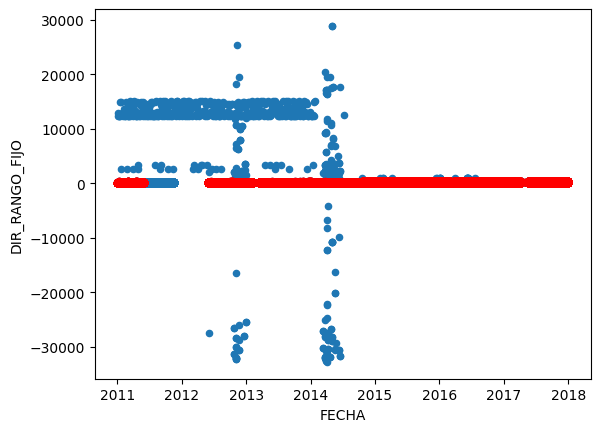

In [52]:
ax = dfVar.plot(kind = 'scatter', x='FECHA', y='DIRECVIENTO')
dfVar.plot(kind = 'scatter', x='FECHA', y='DIR_RANGO_FIJO', ax=ax, color='red')

<Axes: xlabel='FECHA', ylabel='VEL_RANGO_FIJO'>

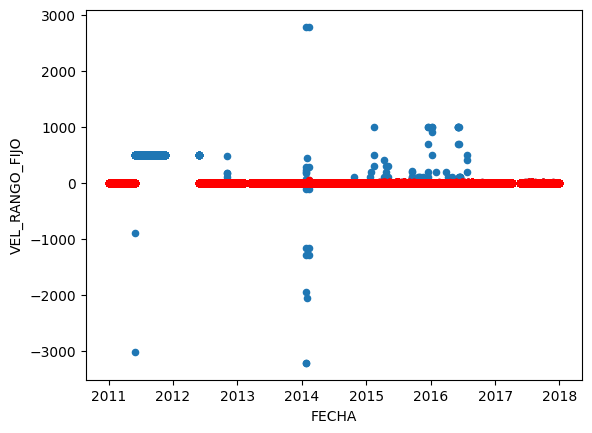

In [53]:
ax = dfVar.plot(kind = 'scatter', x='FECHA', y='VELVIENTO')
dfVar.plot(kind = 'scatter', x='FECHA', y='VEL_RANGO_FIJO', ax=ax, color='red')

In [54]:
dfVar['FECHA_DIA'] = dfVar['FECHA'].dt.date
dfVar['FECHA_HORA'] = dfVar['FECHA'].dt.hour


dfAux = (dfVar.groupby('FECHA_DIA')
       .agg({'DIR_RANGO_FIJO': ['mean', 'min', 'max'],
             'VEL_RANGO_FIJO': ['mean', 'min', 'max']}
            )
       .reset_index(level = [0])
)

check_size_list_2 = lambda r: 0 if ((np.isnan(r[-1])) | ((all([x == r[-1] for x in r])) & len(r) == 3)) else 1
check_size_list_5 = lambda r: 0 if ((np.isnan(r[-1])) | ((all([x == r[-1] for x in r])) & len(r) == 6)) else 1

dfAux = (dfAux.sort_values(by = 'FECHA_DIA'))

dfAux['VEL_PROM_D_1'] = (dfAux[('VEL_RANGO_FIJO', 'mean')].shift(1))
dfAux['DIR_PROM_D_1'] = (dfAux[('DIR_RANGO_FIJO', 'mean')].shift(1))

dfAux['VEL_PROM_LIST_D_2'] = [window.to_list() for window in dfAux[('VEL_RANGO_FIJO', 'mean')].rolling(window=3)]
dfAux['NO_REPETIDO_VEL_PROM_D_2'] = dfAux['VEL_PROM_LIST_D_2'].apply(check_size_list_2)

dfAux['VEL_MAX_LIST_D_2'] = [window.to_list() for window in dfAux[('VEL_RANGO_FIJO', 'max')].rolling(window=3)]
dfAux['NO_REPETIDO_VEL_MAX_D_2'] = dfAux['VEL_MAX_LIST_D_2'].apply(check_size_list_2)

dfAux['DIR_PROM_LIST_D_2'] = [window.to_list() for window in dfAux[('DIR_RANGO_FIJO', 'mean')].rolling(window=3)]
dfAux['NO_REPETIDO_DIR_PROM_D_2'] = dfAux['DIR_PROM_LIST_D_2'].apply(check_size_list_2)

dfCons = (pd.merge(dfVar,dfAux,on='FECHA_DIA', how='outer')
            .rename(columns = { ('DIR_RANGO_FIJO', 'mean') : 'DIR_PROM_DIARIA',
                                ('DIR_RANGO_FIJO', 'min') : 'DIR_MIN_DIARIA',
                                ('DIR_RANGO_FIJO', 'max') : 'DIR_MAX_DIARIA',
                                ('VEL_RANGO_FIJO', 'mean') : 'VEL_PROM_DIARIA',
                                ('VEL_RANGO_FIJO', 'min') : 'VEL_MIN_DIARIA',
                                ('VEL_RANGO_FIJO', 'max') : 'VEL_MAX_DIARIA',
                                ('VEL_PROM_D_1', ''): 'VEL_PROM_D_1',
                                ('DIR_PROM_D_1', ''): 'DIR_PROM_D_1',
                                ('NO_REPETIDO_VEL_PROM_D_2', ''): 'NO_REPETIDO_VEL_PROM_D_2',
                                ('NO_REPETIDO_VEL_MAX_D_2', ''): 'NO_REPETIDO_VEL_MAX_D_2',
                                ('NO_REPETIDO_DIR_PROM_D_2', ''): 'NO_REPETIDO_DIR_PROM_D_2',
                               })
        )

######################################################################################

dfAux2 = (dfVar.rename(columns = {'DIR_RANGO_FIJO' : 'DIR_RANGO_FIJO_MINUTO',
                                  'VEL_RANGO_FIJO' : 'VEL_RANGO_FIJO_MINUTO'})
              .groupby(['FECHA_DIA', 'FECHA_HORA'])
              .agg({'DIR_RANGO_FIJO_MINUTO': ['mean', 'min', 'max'],
                    'VEL_RANGO_FIJO_MINUTO': ['mean', 'min', 'max']}
                    )
              .reset_index(level = [0]).reset_index(level = [0])
)

dfAux2['VEL_PROM_H_1'] = (dfAux2[('VEL_RANGO_FIJO_MINUTO', 'mean')].shift(1))
dfAux2['DIR_PROM_H_1'] = (dfAux2[('DIR_RANGO_FIJO_MINUTO', 'mean')].shift(1))

dfAux2['VEL_PROM_LIST_H_5'] = [window.to_list() for window in dfAux2[('VEL_RANGO_FIJO_MINUTO', 'mean')].rolling(window=6)]
dfAux2['NO_REPETIDO_VEL_PROM_H_5'] = dfAux2['VEL_PROM_LIST_H_5'].apply(check_size_list_5)

dfAux2['DIR_PROM_LIST_H_5'] = [window.to_list() for window in dfAux2[('DIR_RANGO_FIJO_MINUTO', 'mean')].rolling(window=6)]
dfAux2['NO_REPETIDO_DIR_PROM_H_5'] = dfAux2['DIR_PROM_LIST_H_5'].apply(check_size_list_5)

dfCons = (pd.merge(dfCons,dfAux2, on=['FECHA_DIA', 'FECHA_HORA'], how='outer')
            .rename(columns = { ('DIR_RANGO_FIJO_MINUTO', 'mean') : 'DIR_PROM_HORA',
                                ('DIR_RANGO_FIJO_MINUTO', 'min') : 'DIR_MIN_HORA',
                                ('DIR_RANGO_FIJO_MINUTO', 'max') : 'DIR_MAX_HORA',
                                ('VEL_RANGO_FIJO_MINUTO', 'mean') : 'VEL_PROM_HORA',
                                ('VEL_RANGO_FIJO_MINUTO', 'min') : 'VEL_MIN_HORA',
                                ('VEL_RANGO_FIJO_MINUTO', 'max') : 'VEL_MAX_HORA',
                                ('VEL_PROM_H_1', ''): 'VEL_PROM_H_1',
                                ('DIR_PROM_H_1', ''): 'DIR_PROM_H_1',
                                ('NO_REPETIDO_VEL_PROM_H_5', ''): 'NO_REPETIDO_VEL_PROM_H_5',
                                ('NO_REPETIDO_DIR_PROM_H_5', ''): 'NO_REPETIDO_DIR_PROM_H_5',
                               })
         )

dfCons['FECHA_DIA'] = dfCons['FECHA_DIA'].apply(lambda x: x.strftime('%Y-%m-%d'))

dfCons['FORM_2_52'] = np.where(dfCons['VEL_MAX_DIARIA'] > dfCons['VEL_PROM_DIARIA'], 1, 0)

dfCons['DIR_NULL_ZERO'] = np.where((dfCons['DIR_RANGO_FIJO'] == 0.0) | (dfCons['DIR_RANGO_FIJO'].isnull()), 1, 0) # 1 cuando es 0 o nulo. 0 en los otros casos
dfCons['VEL_NULL_ZERO'] = np.where((dfCons['VEL_RANGO_FIJO'] == 0.0) | (dfCons['VEL_RANGO_FIJO'].isnull()), 1, 0) # 1 cuando es 0 o nulo. 0 en los otros casos

dfCons['FORM_2_54'] = np.where((dfCons['FORM_2_52'] == 1) &
                                (
                                 (dfCons['DIR_NULL_ZERO'] == 0.0) | 
                                 ((dfCons['DIR_NULL_ZERO'] == 1) & (dfCons['VEL_NULL_ZERO'] == 0))
                                ), 1, 0)

dfCons['FORM_2_55'] = np.where((dfCons['FORM_2_54'] == 1) &
                                (
                                 (dfCons['VEL_NULL_ZERO'] == 0.0) | 
                                 ((dfCons['VEL_NULL_ZERO'] == 1) & (dfCons['DIR_NULL_ZERO'] == 0))
                                ), 1, 0)

dfCons['FORM_2_56'] = np.where((dfCons['FORM_2_55'] == 1) &
                                ( abs(dfCons['VEL_PROM_DIARIA'] - dfCons['VEL_PROM_D_1']) < 10.0), 1, 0)

dfCons['FORM_2_57'] = np.where((dfCons['FORM_2_56'] == 1) &
                                ( abs(dfCons['VEL_PROM_HORA'] - dfCons['VEL_PROM_H_1']) < 7.5), 1, 0)

dfCons['DIR_ABS_D_1'] = abs(dfCons['DIR_PROM_DIARIA'] - dfCons['DIR_PROM_D_1'])
dfCons['DIR_ABS_D_1_360'] = 360.0 - abs(dfCons['DIR_PROM_DIARIA'] - dfCons['DIR_PROM_D_1'])
dfCons['DIR_ABS_H_1'] = abs(dfCons['DIR_PROM_HORA'] - dfCons['DIR_PROM_H_1'])
dfCons['DIR_ABS_H_1_360'] = 360.0 - abs(dfCons['DIR_PROM_HORA'] - dfCons['DIR_PROM_H_1'])
dfCons['MIN_DIR_ABS_D_1'] = dfCons[['DIR_ABS_D_1', 'DIR_ABS_D_1_360']].min(axis=1)
dfCons['MIN_DIR_ABS_H_1'] = dfCons[['DIR_ABS_H_1', 'DIR_ABS_H_1_360']].min(axis=1)

dfCons['FORM_2_58'] = np.where((dfCons['FORM_2_57'] == 1) &
                                ( dfCons['MIN_DIR_ABS_D_1'] < 150.0), 1, 0)

dfCons['FORM_2_59'] = np.where((dfCons['FORM_2_58'] == 1) &
                                ( dfCons['MIN_DIR_ABS_H_1'] < 150.0), 1, 0)

dfCons['FORM_2_60'] = np.where((dfCons['FORM_2_59'] == 1) & (dfCons['NO_REPETIDO_VEL_PROM_D_2'] == 1), 1, 0)
dfCons['FORM_2_61'] = np.where((dfCons['FORM_2_60'] == 1) & (dfCons['NO_REPETIDO_VEL_MAX_D_2'] == 1), 1, 0)
dfCons['FORM_2_62'] = np.where((dfCons['FORM_2_61'] == 1) & (dfCons['NO_REPETIDO_DIR_PROM_D_2'] == 1), 1, 0)
dfCons['FORM_2_63'] = np.where((dfCons['FORM_2_62'] == 1) & (dfCons['NO_REPETIDO_VEL_PROM_H_5'] == 1), 1, 0)
dfCons['FORM_2_64'] = np.where((dfCons['FORM_2_63'] == 1) & (dfCons['NO_REPETIDO_DIR_PROM_H_5'] == 1), 1, 0)

####  Quedamos en la formula 2.64 #####

<ipython-input-54-696d433a7afd>:29: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  dfCons = (pd.merge(dfVar,dfAux,on='FECHA_DIA', how='outer')
<ipython-input-54-696d433a7afd>:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  dfCons = (pd.merge(dfVar,dfAux,on='FECHA_DIA', how='outer')
<ipython-input-54-696d433a7afd>:64: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  dfCons = (pd.merge(dfCons,dfAux2, on=['FECHA_DIA', 'FECHA_HORA'], how='outer')
<ipython-input-54-696d433a7afd>:64: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  dfCons = (pd.merge(dfCons,dfAux2, on=['FECHA_DIA', 'FECHA_HORA'], how='outer')


In [55]:
## Para filtrar los valores finales
dfFinal = dfCons[dfCons['FORM_2_64'] == 1].reset_index(drop=True)
dfFinal 

,FECHA,VELVIENTO,DIRECVIENTO,DIR_RANGO_FIJO,VEL_RANGO_FIJO,FECHA_DIA,FECHA_HORA,DIR_PROM_DIARIA,DIR_MIN_DIARIA,DIR_MAX_DIARIA,...,DIR_ABS_H_1_360,MIN_DIR_ABS_D_1,MIN_DIR_ABS_H_1,FORM_2_58,FORM_2_59,FORM_2_60,FORM_2_61,FORM_2_62,FORM_2_63,FORM_2_64
0,2011-01-02 00:00:00-05:00,0.2,34.0,34.0,0.2,2011-01-02,0,26.659722,1.0,244.0,...,356.333333,3.284334,3.666667,1,1,1,1,1,1,1
1,2011-01-02 00:10:00-05:00,0.2,1.0,1.0,0.2,2011-01-02,0,26.659722,1.0,244.0,...,356.333333,3.284334,3.666667,1,1,1,1,1,1,1
2,2011-01-02 00:20:00-05:00,0.2,1.0,1.0,0.2,2011-01-02,0,26.659722,1.0,244.0,...,356.333333,3.284334,3.666667,1,1,1,1,1,1,1
3,2011-01-02 00:30:00-05:00,0.1,1.0,1.0,0.1,2011-01-02,0,26.659722,1.0,244.0,...,356.333333,3.284334,3.666667,1,1,1,1,1,1,1
4,2011-01-02 00:40:00-05:00,0.1,1.0,1.0,0.1,2011-01-02,0,26.659722,1.0,244.0,...,356.333333,3.284334,3.666667,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241984,2017-12-31 23:10:00-05:00,0.3,288.0,288.0,0.3,2017-12-31,23,184.465278,0.0,357.0,...,231.000000,34.868056,129.000000,1,1,1,1,1,1,1
241985,2017-12-31 23:20:00-05:00,0.2,287.0,287.0,0.2,2017-12-31,23,184.465278,0.0,357.0,...,231.000000,34.868056,129.000000,1,1,1,1,1,1,1
241986,2017-12-31 23:30:00-05:00,0.2,331.0,331.0,0.2,2017-12-31,23,184.465278,0.0,357.0,...,231.000000,34.868056,129.000000,1,1,1,1,1,1,1
241987,2017-12-31 23:40:00-05:00,0.3,341.0,341.0,0.3,2017-12-31,23,184.465278,0.0,357.0,...,231.000000,34.868056,129.000000,1,1,1,1,1,1,1


In [56]:
print(dfFinal['VELVIENTO'].max())
print(dfFinal['VEL_MAX_DIARIA'].max())
print(dfFinal['DIRECVIENTO'].max())
print(dfFinal['DIR_MAX_DIARIA'].max())
print(dfFinal['VELVIENTO'].mean())


12.2
55.6
360.0
360.0
0.9033778394885718


In [57]:
print(dfFinal['VELVIENTO'].min())
print(dfFinal['VEL_MIN_DIARIA'].min())
print(dfFinal['DIRECVIENTO'].min())
print(dfFinal['DIR_MIN_DIARIA'].min())
print(dfFinal['DIRECVIENTO'].mean())

0.0
0.0
0.0
0.0
119.7291901698011


In [58]:
print(f'Datos iniciales : {dfVar.shape[0]}')
print(f'Datos nulos iniciales : {dfVar[(dfVar["DIRECVIENTO"].isnull()) | (dfVar["VELVIENTO"].isnull())].shape[0]}')
dfviento_null= dfVar[(dfVar["DIRECVIENTO"].isnull()) | (dfVar["VELVIENTO"].isnull())]
print(f'Datos nulos después de los testes : {dfFinal[(dfFinal["DIR_RANGO_FIJO"].isnull()) | (dfFinal["VEL_RANGO_FIJO"].isnull())].shape[0]}')
print(f'Datos finales después de testes : {dfFinal.shape[0]}')
print(f'Datos no nulos que fueron eliminados en los testes : {dfVar.shape[0] - dfFinal.shape[0] - dfVar[(dfVar["DIRECVIENTO"].isnull()) | (dfVar["VELVIENTO"].isnull())].shape[0]}')

Datos iniciales : 290610
Datos nulos iniciales : 13009
Datos nulos después de los testes : 0
Datos finales después de testes : 241989
Datos no nulos que fueron eliminados en los testes : 35612


In [59]:
(dfFinal[['FECHA', 'DIR_RANGO_FIJO', 'VEL_RANGO_FIJO']]
          .rename(columns = {'DIR_RANGO_FIJO' : 'DIRECVIENTO',
                                  'VEL_RANGO_FIJO' : 'VELVIENTO'})
          .to_csv(PATH_FINAL_DADOS_TRATADOS + FILE_DATOS_TRATADOS, header=True, index=False, sep = ';'))

In [60]:
dfviento_null

,FECHA,VELVIENTO,DIRECVIENTO,DIR_RANGO_FIJO,VEL_RANGO_FIJO,FECHA_DIA,FECHA_HORA
21670,2011-05-31 11:50:00-05:00,NaN,NaN,NaN,NaN,2011-05-31,11
21671,2011-05-31 12:00:00-05:00,NaN,NaN,NaN,NaN,2011-05-31,12
21672,2011-05-31 12:10:00-05:00,NaN,NaN,NaN,NaN,2011-05-31,12
21673,2011-05-31 12:20:00-05:00,NaN,NaN,NaN,NaN,2011-05-31,12
21674,2011-05-31 12:30:00-05:00,NaN,NaN,NaN,NaN,2011-05-31,12
...,...,...,...,...,...,...,...
260584,2017-04-06 12:10:00-05:00,NaN,NaN,NaN,NaN,2017-04-06,12
260732,2017-05-20 09:00:00-05:00,NaN,NaN,NaN,NaN,2017-05-20,9
283972,2017-11-12 09:00:00-05:00,NaN,NaN,NaN,NaN,2017-11-12,9
289543,2017-12-22 00:00:00-05:00,NaN,NaN,NaN,NaN,2017-12-22,0


In [61]:
dfviento_null['FECHA'] = pd.to_datetime(dfviento_null['FECHA'], format='%Y %m %d %H %M').dt.tz_convert('America/Bogota')

<ipython-input-61-27ec09deed68>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfviento_null['FECHA'] = pd.to_datetime(dfviento_null['FECHA'], format='%Y %m %d %H %M').dt.tz_convert('America/Bogota')


In [62]:
dfviento_null['HORA_FECHA'] = dfviento_null['FECHA'].dt.hour
dfviento_null['MES_FECHA'] = dfviento_null['FECHA'].dt.month
dfviento_null['ANO_FECHA'] = dfviento_null['FECHA'].dt.year
dfviento_null

<ipython-input-62-068734f17618>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfviento_null['HORA_FECHA'] = dfviento_null['FECHA'].dt.hour
<ipython-input-62-068734f17618>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfviento_null['MES_FECHA'] = dfviento_null['FECHA'].dt.month
<ipython-input-62-068734f17618>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

,FECHA,VELVIENTO,DIRECVIENTO,DIR_RANGO_FIJO,VEL_RANGO_FIJO,FECHA_DIA,FECHA_HORA,HORA_FECHA,MES_FECHA,ANO_FECHA
21670,2011-05-31 11:50:00-05:00,NaN,NaN,NaN,NaN,2011-05-31,11,11,5,2011
21671,2011-05-31 12:00:00-05:00,NaN,NaN,NaN,NaN,2011-05-31,12,12,5,2011
21672,2011-05-31 12:10:00-05:00,NaN,NaN,NaN,NaN,2011-05-31,12,12,5,2011
21673,2011-05-31 12:20:00-05:00,NaN,NaN,NaN,NaN,2011-05-31,12,12,5,2011
21674,2011-05-31 12:30:00-05:00,NaN,NaN,NaN,NaN,2011-05-31,12,12,5,2011
...,...,...,...,...,...,...,...,...,...,...
260584,2017-04-06 12:10:00-05:00,NaN,NaN,NaN,NaN,2017-04-06,12,12,4,2017
260732,2017-05-20 09:00:00-05:00,NaN,NaN,NaN,NaN,2017-05-20,9,9,5,2017
283972,2017-11-12 09:00:00-05:00,NaN,NaN,NaN,NaN,2017-11-12,9,9,11,2017
289543,2017-12-22 00:00:00-05:00,NaN,NaN,NaN,NaN,2017-12-22,0,0,12,2017


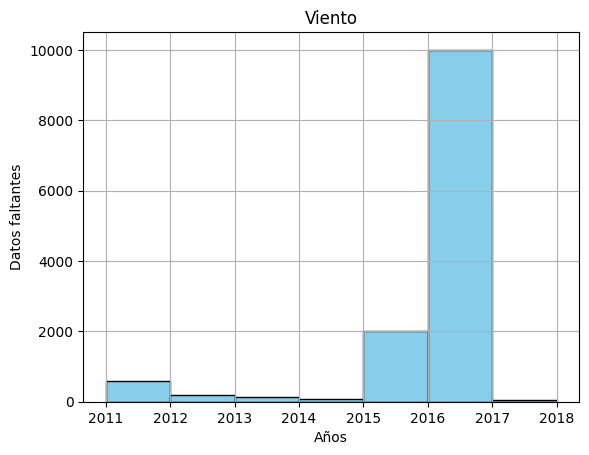

In [63]:
fig, ax = plt.subplots()

# Gráfico del histograma
dfviento_null['ANO_FECHA'].plot(kind = 'hist', ax=ax, edgecolor='black', color='skyblue', bins = range(2011, 2019))

# # Gráfico de la estimativa de la densidad del kernel en el mismo gráfico sobre el mismo gráfico
# ax2 = df['hour_min_t'].plot(kind='kde', secondary_y=True, ax=ax, color='red')
# ax2.set_ylabel("Densidad")

ax.set_ylim(0)
ax.set_xlim()
ax.grid(True)
ax.set_xlabel("Años")
ax.set_xticks(range(2011, 2019))
ax.set_title('Viento')
ax.set_ylabel("Datos faltantes")
plt.savefig(PATH_DRIVE + PATH_FIGURE + f'Histograma_año_datos_faltantes_viento_{NOMBRE_ESTACION}.png', format='png')

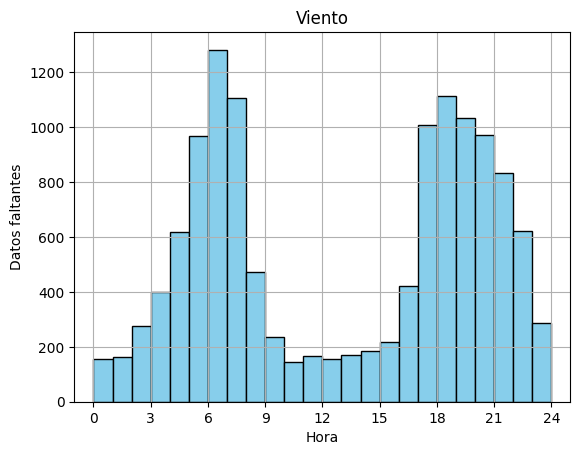

In [64]:
fig, ax = plt.subplots()

# Gráfico del histograma
dfviento_null['HORA_FECHA'].plot(kind = 'hist', ax=ax, edgecolor='black', color='skyblue', bins = range(0, 25))

# # Gráfico de la estimativa de la densidad del kernel en el mismo gráfico sobre el mismo gráfico
# ax2 = df['hour_min_t'].plot(kind='kde', secondary_y=True, ax=ax, color='red')
# ax2.set_ylabel("Densidad")

ax.set_ylim(0)
ax.set_xlim(-1, 25)
ax.grid(True)
ax.set_xlabel("Hora")
ax.set_xticks(range(0, 25, 3))
ax.set_title('Viento')
ax.set_ylabel("Datos faltantes")
plt.savefig(PATH_DRIVE + PATH_FIGURE + f'Histograma_hora_datos_faltantes_viento_{NOMBRE_ESTACION}.png', format='png')

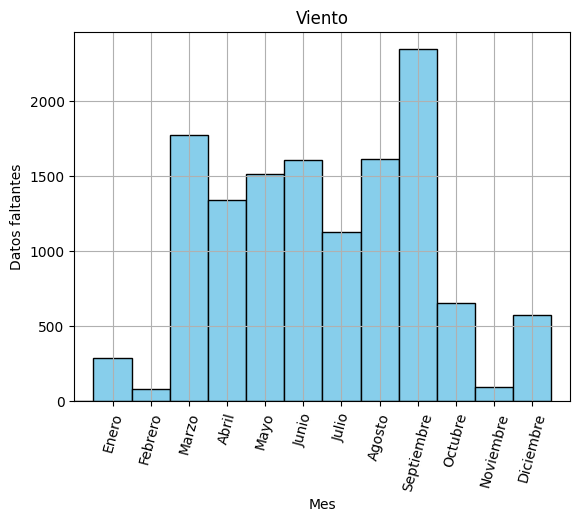

In [65]:
fig, ax = plt.subplots()

# Gráfico del histograma
dfviento_null['MES_FECHA'].plot(kind = 'hist', ax=ax, edgecolor='black', color='skyblue', bins = range(0,14), align='left')

# # Gráfico de la estimativa de la densidad del kernel en el mismo gráfico sobre el mismo gráfico
# ax2 = df['month_min_t'].plot(kind='kde', secondary_y=True, ax=ax, color='red')
# ax2.set_ylabel("Densidad")

ax.set_ylim(0)
ax.set_xlim(0, 13)
# bins_labels(range(0,14), 20)
ax.grid(True)
ax.set_xlabel("Mes")
ax.set_xticks(range(1, 13, 1))
Meses = ['Enero', 'Febrero', 
         'Marzo', 'Abril', 
         'Mayo', 'Junio', 
         'Julio', 'Agosto', 
         'Septiembre', 'Octubre', 
         'Noviembre', 'Diciembre']
ax.set_xticklabels(Meses, rotation=75)
ax.set_title('Viento')
ax.set_ylabel("Datos faltantes")
plt.savefig(PATH_DRIVE + PATH_FIGURE + f'Histograma_mes_datos_faltantes_viento_{NOMBRE_ESTACION}.png', format='png')

## Análisis de datos faltantes

In [66]:
from calendar import isleap

In [67]:
dfEliminados = dfCons[dfCons['FORM_2_64'] == 0].reset_index(drop=True)[['FECHA', 'VELVIENTO']].copy()
dfEliminados['HORA_FECHA'] = dfEliminados['FECHA'].dt.hour
dfEliminados['MES_FECHA'] = dfEliminados['FECHA'].dt.month
dfEliminados['ANO_FECHA'] = dfEliminados['FECHA'].dt.year
dfEliminados['DIAS_EN_MES'] = dfEliminados['FECHA'].dt.days_in_month
dfEliminados['DIAS_EN_ANO'] = dfEliminados["ANO_FECHA"].apply(lambda x:365 + isleap(x))

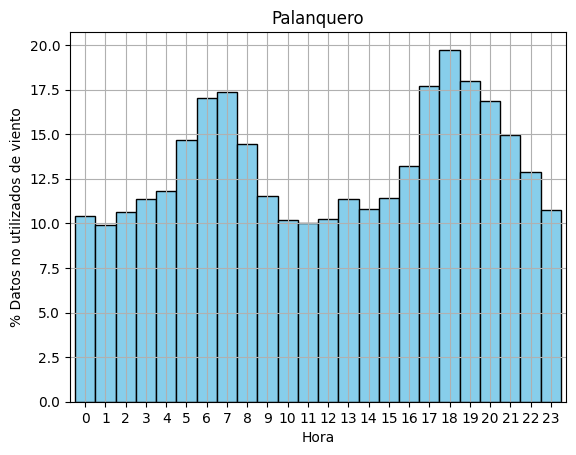

In [68]:
dfEliminados_HORA = (dfEliminados.groupby('HORA_FECHA')
       .agg({'HORA_FECHA': ['count']})
       .reset_index(level = [0])
      )

dfEliminados_HORA["TOTAL_FALTANTES"] = dfEliminados_HORA[("HORA_FECHA", "count")]
dfEliminados_HORA["HORA"] = dfEliminados_HORA[("HORA_FECHA", "")]
dfEliminados_HORA["TOTAL_HORA"] = 7*365*6
dfEliminados_HORA["PORC_HORA_FALTANTE"] = dfEliminados_HORA["TOTAL_FALTANTES"] / dfEliminados_HORA["TOTAL_HORA"] * 100

fig, ax = plt.subplots()

dfEliminados_HORA.plot.bar(x='HORA', y='PORC_HORA_FALTANTE', rot=0, edgecolor='black', color='skyblue', width=1.0, ax=ax)
ax.grid(True)
ax.set_xlabel("Hora")
ax.set_ylabel("% Datos no utilizados de viento")
ax.get_legend().remove()
ax.set_title(f'{NOMBRE_ESTACION.capitalize()}')
plt.savefig(PATH_DRIVE + PATH_FIGURE + f'Histograma_datos_faltantes_porcentual_viento_hora_{NOMBRE_ESTACION}.png', format='png')

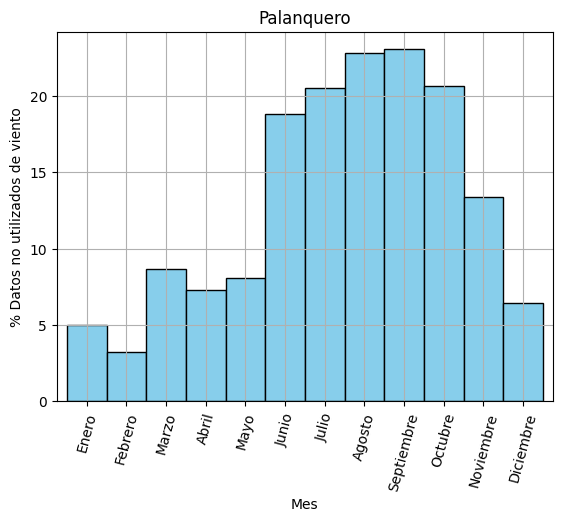

In [69]:
dfEliminados_MES = (dfEliminados
       .groupby(['MES_FECHA', 'ANO_FECHA', 'DIAS_EN_MES'])
       .agg({'HORA_FECHA': ['count']})
       .reset_index(level = [0, 1, 2])
      )

dfEliminados_MES["TOTAL_FALTANTES"] = dfEliminados_MES[("HORA_FECHA", "count")]
dfEliminados_MES = dfEliminados_MES.drop(columns=[("HORA_FECHA", "count")])
dfEliminados_MES["TOTAL_DATOS_POR_MES_ANO"] = dfEliminados_MES['DIAS_EN_MES']*24*7*6
dfEliminados_MES["PORC_DATOS_POR_MES_ANO_FALTANTE"] = dfEliminados_MES["TOTAL_FALTANTES"] / dfEliminados_MES["TOTAL_DATOS_POR_MES_ANO"] * 100
dfEliminados_MES.columns=dfEliminados_MES.columns.droplevel(1)
dfEliminados_MES.reset_index(inplace=True)
dfEliminados_MES = (dfEliminados_MES
       .groupby('MES_FECHA')
       .agg({'PORC_DATOS_POR_MES_ANO_FALTANTE': ['sum']})
       .reset_index(level = [0])
      )
dfEliminados_MES["PORC_MES_FALTANTES"] = dfEliminados_MES[("PORC_DATOS_POR_MES_ANO_FALTANTE", "sum")]

fig, ax = plt.subplots()

dfEliminados_MES.plot.bar(x='MES_FECHA', y='PORC_MES_FALTANTES', rot=0, edgecolor='black', color='skyblue', width=1.0, ax=ax)
ax.grid(True)
ax.set_xlabel("Mes")
ax.set_ylabel("% Datos no utilizados de viento")
ax.get_legend().remove()
Meses = ['Enero', 'Febrero', 
         'Marzo', 'Abril', 
         'Mayo', 'Junio', 
         'Julio', 'Agosto', 
         'Septiembre', 'Octubre', 
         'Noviembre', 'Diciembre']
ax.set_xticklabels(Meses, rotation=75)
ax.set_title(f'{NOMBRE_ESTACION.capitalize()}')
plt.savefig(PATH_DRIVE + PATH_FIGURE + f'Histograma_datos_faltantes_porcentual_viento_mes_{NOMBRE_ESTACION}.png', format='png')

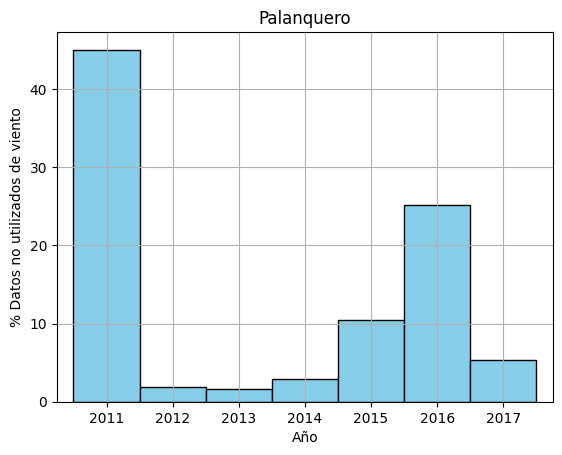

In [70]:
dfEliminados_ANO = (dfEliminados
       .groupby(['ANO_FECHA', 'DIAS_EN_ANO'])
       .agg({'HORA_FECHA': ['count']})
       .reset_index(level = [0, 1])
      )

dfEliminados_ANO["TOTAL_FALTANTES"] = dfEliminados_ANO[("HORA_FECHA", "count")]
dfEliminados_ANO = dfEliminados_ANO.drop(columns=[("HORA_FECHA", "count")])
dfEliminados_ANO["TOTAL_DATOS_POR_ANO"] = dfEliminados_ANO['DIAS_EN_ANO']*24*6
dfEliminados_ANO["PORC_ANO_FALTANTES"] = dfEliminados_ANO["TOTAL_FALTANTES"] / dfEliminados_ANO["TOTAL_DATOS_POR_ANO"] * 100
dfEliminados_ANO
fig, ax = plt.subplots()

dfEliminados_ANO.plot.bar(x='ANO_FECHA', y='PORC_ANO_FALTANTES', rot=0, edgecolor='black', color='skyblue', width=1.0, ax=ax)
ax.grid(True)
ax.set_xlabel("Año")
ax.set_ylabel("% Datos no utilizados de viento")
ax.get_legend().remove()
ax.set_title(f'{NOMBRE_ESTACION.capitalize()}')
plt.savefig(PATH_DRIVE + PATH_FIGURE + f'Histograma_datos_faltantes_porcentual_viento_ano_{NOMBRE_ESTACION}.png', format='png')